<a href="https://colab.research.google.com/github/krits29/global-malnutrition/blob/main/Data_Analysis_Malnutrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Malnutrition Across the Globe

In [ ]:
"""

This file retrieves, cleans, and merges the data needed
for our final project about child malnutrition.

"""

!pip install geopandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import PartialDependenceDisplay
import geopandas as gpd
import math
from typing import Any
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.1 MB/s eta 0:00:00


DELETE LATER: Here's a reference colab of another group
https://colab.research.google.com/drive/1mwW_PR-OUXfCYsJyKel3We8qO0JwOwiM

Steps
1. Analyze the provided dataset and break down which sections to utilize in the project, and split up the rest of the tasks
2. Clean up the dataset, and create filter and subdatasets to assist certain research questions. Merge additional datasets
3. Determine and plot which relationships to help answer the research questions
4. Determine and calculate the overall malnutrition number associated with each country, and add another column to the overall dataset
5. Code the machine learning model for the updated dataset and determine accuracy by running on testing data
6. Recheck all work completed from each team member and determine if any mistakes need to be corrected along with cleaning up all code, adding comments, and passing flake8


In [ ]:
def filter_malnutrition_data(filename: str) -> pd.DataFrame:
  """
  This function takes a str filname and returns a pandas
  DataFrame of filtered data without NaN values. Adds "Average"
  column that calculates the average percent of all four factors
  of malnutrition. Converts values in Income Classification from
  integers to strings.
  """

  malnutrition_data = pd.read_csv(filename)
  malnutrition_data['Average'] = (malnutrition_data.Overweight +
                                  malnutrition_data.Underweight +
                                  malnutrition_data.Wasting +
                                  malnutrition_data.Stunting / 4)
  malnutrition_data = malnutrition_data.dropna()
  malnutrition_data["Income Classification"] = malnutrition_data["Income Classification"].astype(str)
  return malnutrition_data

In [ ]:
def map_data(filename: str, data: pd.DataFrame) -> pd.DataFrame:
  """
  This functions takes str filename of geospatial data and a
  pandas DataFrame. Returns a merged pandas DataFrame of
  the GDP DataFrame and the pandas DataFrame. Filter the
  GDP DataFrame to only include columns "name" and "geometry"
  """

  countries = gpd.read_file(gpd.datasets.get_path(filename))
  countries = countries[["name", "geometry"]]
  countries["name"] = countries["name"].str.upper()
  merged = countries.merge(data, left_on='name',
                           right_on='Country',how="left")
  return merged

In [ ]:
def filter_cost_data(filename: str) -> pd.DataFrame:
  """
  This functions takes a str filename and returns a pandas
  DataFrame of filtered and merged data. Splits the data into
  two DataFrames that each contain only the "Area" and "Y2017"
  columns. One DF only has the "Cost of health diet (PPP dollar
  per person per day)" row, and the other only has "Percentage of
  the population unable to afford a healthy diet (percent)" row.
  These DataFrames are merged together.
  """

  cost_data = pd.read_csv(filename, encoding='iso-8859-1')
  cost_data["Area"] = cost_data["Area"].str.upper()
  cost_data = cost_data[["Area", "Item", "Y2017"]]

  # Create "Cost of Health Diet" column
  healthy_diet_cost = cost_data[cost_data["Item"] == "Cost of a healthy diet (PPP dollar per person per day)"]
  healthy_diet_cost = healthy_diet_cost[["Area", "Y2017"]]
  healthy_diet_cost.rename(columns={"Y2017":"Cost of Healthy Diet"}, inplace=True)

  # Create "Percentage Unable to Afford" column
  percent_unable_afford = (cost_data[cost_data["Item"] ==
                                     "Percentage of the population unable to afford a healthy diet (percent)"])
  percent_unable_afford = percent_unable_afford[["Area", "Y2017"]]
  percent_unable_afford.rename(columns={"Y2017":"Percentage Unable to Afford"}, inplace=True)

  # Merge two DataFrames
  merged_cost_data = pd.merge(healthy_diet_cost, percent_unable_afford, on="Area")
  return merged_cost_data

In [ ]:
def merge_cost_and_malnutrition(cost_data: pd.DataFrame, malnutrition_data: pd.DataFrame):
  """
  Takes two pandas DataFrames and returns a merged DataFrame without NaN values.
  """

  merged = malnutrition_data.merge(cost_data, left_on='Country', right_on='Area',how="left")
  merged = merged.dropna()
  return mergedNi

# Research Question #1

In which countries are the forms (stunting, wasting, overweight, and underweight) of child malnutrition most prevalent? Are there regional or income-level similarities between these countries?

In [ ]:
def plot_top_ten_stunting(data: pd.DataFrame) -> None:
  """
  This function takes a pandas DataFrame and plots a bar graph (with x-axis Country,
  y-axis Percentage Stunting, and title Percentage Stunting of Top 10 Countries
  with Highest Levels) that visualizes the percent stunting of under five population
  for the top 10 countries with the highest values, colored by Income Classification.
  Does not return anything.
  """

  # data = filter_malnutrition_data('country-wise-average.csv')
  data = data.nlargest(n=10, columns=['Stunting'])[["Country", "Stunting", "Income Classification"]]
  graph = px.bar(data, x='Country', y='Stunting', color='Income Classification', color_discrete_sequence=["#2B0E75", "#6B46C2", "#9F8DC9"])
  graph.update_layout(title='Percentage Stunting of Top 10 Countries with Highest Levels',
                    xaxis_title='Country', yaxis_title='Percentage Stunting')
  graph.show()


# DELETE
plot_top_ten_stunting(malnutrition_data)

In [ ]:
def plot_top_wasting(data: pd.DataFrame) -> None:
  """
  This function takes a pandas DataFrame and plots a bar graph (with x-axis Country,
  y-axis Percentage Wasting, and title Percentage Wasting of Top 10 Countries
  with Highest Levels) that visualizes the percent wasting of under five population
  for the top 10 countries with the highest values, colored by Income Classification.
  Does not return anything.
  """

  data = data.nlargest(n=10, columns=['Wasting'])[["Country", "Wasting", "Income Classification"]]
  graph = px.bar(data, x='Country', y='Wasting', color='Income Classification', color_discrete_sequence=["#2B0E75", "#6B46C2", "#9F8DC9"])
  graph.update_layout(title='Percentage Wasting of Top 10 Countries with Highest Levels',
                      xaxis_title='Country', yaxis_title='Percentage Wasting')
  graph.show()


# DELETE
plot_top_wasting(malnutrition_data)

In [ ]:
def plot_top_overweight(data: pd.DataFrame) -> None:
  """
  This function takes a pandas DataFrame and plots a bar graph (with x-axis Country,
  y-axis Percentage Overweight, and title Percentage Overweight of Top 10 Countries
  with Highest Levels) that visualizes the percent overweight of under five population
  for the top 10 countries with the highest values, colored by Income Classification.
  Does not return anything.
  """

  data = data.nlargest(n=10, columns=['Overweight'])[["Country", "Overweight", "Income Classification"]]
  graph = px.bar(data, x='Country', y='Overweight', color='Income Classification', color_discrete_sequence=["#2B0E75", "#6B46C2", "#907AC4"])
  graph.update_layout(title='Percentage Overweight of Top 10 Countries with Highest Levels',
                      xaxis_title='Country', yaxis_title='Percentage Overweight')
  graph.show()


# DELETE
plot_top_overweight(malnutrition_data)

In [ ]:
def plot_top_underweight(data: pd.DataFrame) -> None:
  """
  This function takes a pandas DataFrame and plots a bar graph (with x-axis Country,
  y-axis Percentage Underweight, and title Percentage Underweight of Top 10 Countries
  with Highest Levels) that visualizes the percent underweight of under five population
  for the top 10 countries with the highest values, colored by Income Classification.
  Does not return anything.
  """
  data = data.nlargest(n=10, columns=['Underweight'])[["Country", "Underweight", "Income Classification"]]
  graph = px.bar(data, x='Country', y='Underweight', color='Income Classification', color_discrete_sequence=["#2B0E75", "#6B46C2", "#907AC4"])
  graph.update_layout(title='Percentage Underweight of Top 10 Countries with Highest Levels',
                      xaxis_title='Country', yaxis_title='Percentage Underweight')
  graph.show()

# DELETE
plot_top_underweight(malnutrition_data)

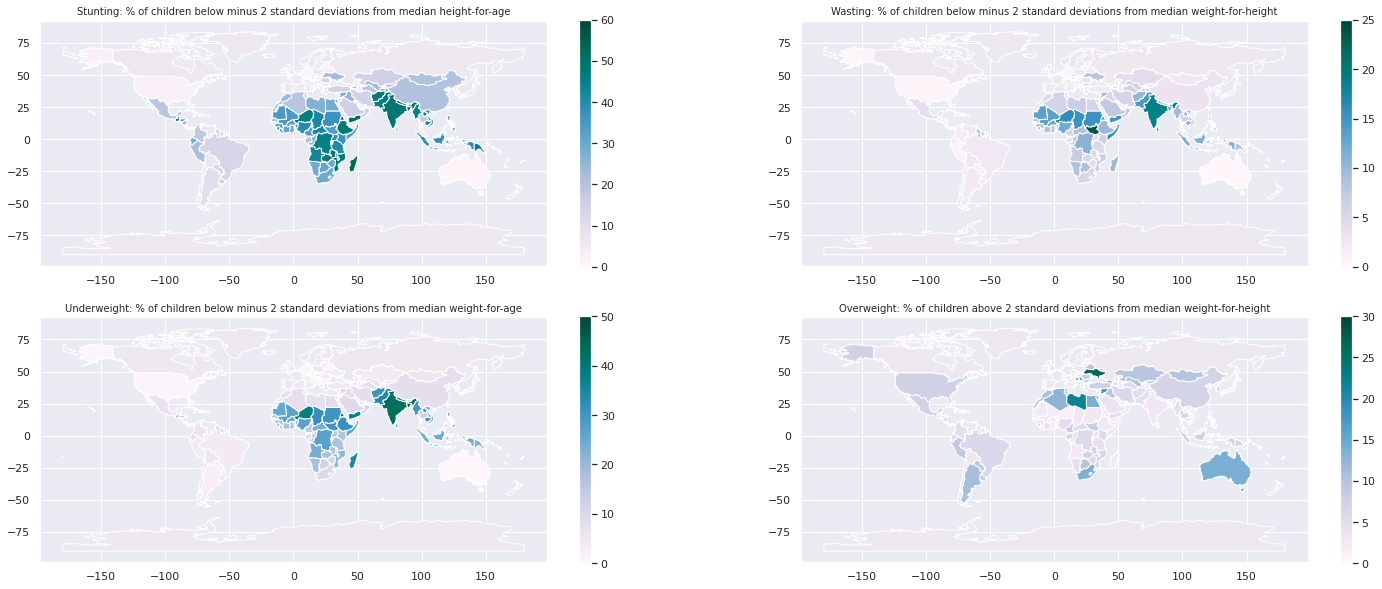

In [ ]:
def plot_global_malnutrition(data: pd.DataFrame) -> None:
  """
  This function takes a pandas DataFrame and produces 4 plots on the same figure showing
  information about the malnutrition levels across the globe by visualizing the percent
  stunting, wasting, underweight, overweight of under five population in all
  the countries there is data for. Does not return anything.
  """
  merged = map_data("naturalearth_lowres", data)
  filtered = merged[["name", "Stunting", "Wasting", "Underweight",
                           "Overweight", "geometry"]]
  fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(25, 10))
  merged.plot(color="#ede8ed", ax=ax1)
  filtered.plot(column='Stunting', legend=True, ax=ax1, vmin=0, vmax=60, cmap="PuBuGn")
  merged.plot(color="#ede8ed", ax=ax2)
  filtered.plot(column='Wasting', legend=True, ax=ax2, vmin=0, vmax=25, cmap="PuBuGn")
  merged.plot(color="#ede8ed", ax=ax3)
  filtered.plot(column='Underweight', legend=True, ax=ax3, vmin=0, vmax=50, cmap="PuBuGn")
  merged.plot(color="#ede8ed", ax=ax4)
  filtered.plot(column='Overweight', legend=True, ax=ax4, vmin=0, vmax=30, cmap="PuBuGn")
  ax1.set_title('Stunting: % of children below minus 2 standard deviations from median height-for-age', fontsize=10)
  ax2.set_title('Wasting: % of children below minus 2 standard deviations from median weight-for-height', fontsize=10)
  ax3.set_title('Underweight: % of children below minus 2 standard deviations from median weight-for-age', fontsize=10)
  ax4.set_title('Overweight: % of children above 2 standard deviations from median weight-for-height', fontsize=10)


# DELETE
plot_global_malnutrition(malnutrition_data)

# Research Question #2
Which countries have the highest and lowest rates of malnutrition, and how do the costs of a healthy diet vary across these countries?

In [ ]:
# Which country has the highest overall malnutrition rate?
def plot_highest_overall(data: pd.DataFrame) -> None:
  data = filter_malnutrition_data('country-wise-average.csv')
  top_avg_data = data.groupby("Country")["Average"].mean().nlargest(10).round()
  top_countries = top_avg_data.index
  fig = px.bar(data, x=top_countries, y=top_avg_data, color = top_countries, color_discrete_sequence= px.colors.sequential.Blues)
  fig.update_layout(
      title="Top 10 Countries with Highest Malnutrition Rate Overall",
      xaxis_title="Country",
      yaxis_title="Average Malnutrition %"
  )
  fig.show()

def plot_lowest_overall(data: pd.DataFrame) -> None:
  data = filter_malnutrition_data('country-wise-average.csv')
  top_avg_data = data.groupby("Country")["Average"].mean().nsmallest(10).round()
  top_countries = top_avg_data.index
  fig = px.bar(data, x=top_countries, y=top_avg_data, color = top_countries, color_discrete_sequence= px.colors.sequential.Blues)
  fig.update_layout(
      title="Top 10 Countries with Lowest Malnutrition Rate Overall",
      xaxis_title="Country",
      yaxis_title="Average Malnutrition %"
  )
  fig.show()

def plot_lowest_cost(data: pd.DataFrame) -> None:
  merged_cost_data = filter_cost_data('/content/Cost_Affordability_Healthy_Diet_Data.csv')

  data = data.merge(merged_cost_data, left_on='Country', right_on='Area',how="left")
  data = data.dropna()[["Income Classification", "Average", "Cost of Healthy Diet", "Percentage Unable to Afford", 'Country']]
  top_avg_data = data.groupby("Country")["Cost of Healthy Diet"].mean().nsmallest(10).round()
  top_countries = top_avg_data.index
  fig = px.bar(data, x=top_countries, y=top_avg_data, color = top_countries, color_discrete_sequence= px.colors.sequential.Blues)
  fig.update_layout(
      title="Top 10 Countries with Lowest Cost of Healthy Diet Overall",
      xaxis_title="Country",
      yaxis_title="Cost (dollar per person per day)"
  )
  fig.show()
  
# DELETE
plot_highest_overall(malnutrition_data)
plot_lowest_overall(malnutrition_data)
plot_lowest_cost(malnutrition_data)


# Which countries have the highest cost for healthy meal per person per day?
malnutrition_data = filter_malnutrition_data('/content/country-wise-average.csv')
merged_cost_data = filter_cost_data('/content/Cost_Affordability_Healthy_Diet_Data.csv')

merged = malnutrition_data.merge(merged_cost_data, left_on='Country', right_on='Area',how="left")
merged = merged.dropna()[["Income Classification", "Average", "Cost of Healthy Diet", "Percentage Unable to Afford", 'Country']]
fig = px.scatter(merged, x="Average", y="Percentage Unable to Afford", color = "Country", title="Percent Unable to Afford Diet vs Average Malnutrition Rate",
                 trendline= 'ols'
              )
fig.update_layout(
    xaxis_title="Average Overall Malnutrition Rate",
    yaxis_title="Percentage of Population Unable to Afford Healthy Diet"
)
fig.show()




# Research Question #3
Can we train an accurate model to predict the average malnutrition levels of a country based on data such as income classification, cost of healthy diet, and the percentage of population unable to afford a healthy diet? 

In [ ]:
# DELETE

from sklearn.datasets import load_diabetes
diabetes = sklearn.datasets.load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tree = DecisionTreeRegressor()
mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(100, 100), tol=1e-2, max_iter=500, random_state=0),
)
tree.fit(X_train, y_train)
mlp.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Decision Tree")
tree_disp = PartialDependenceDisplay.from_estimator(tree, X_train, ["age", "bmi"], ax=ax)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Multi-layer Perceptron")
mlp_disp = PartialDependenceDisplay.from_estimator(
    mlp, X_train, ["age", "bmi"], ax=ax, line_kw={"color": "red"}
)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print('Train MSE:', mean_squared_error(y_train, y_train_pred))
print('Test MSE:', mean_squared_error(y_test, y_test_pred))

NameError: ignored

In [ ]:
# merging
malnutrition_data = filter_malnutrition_data('/content/country-wise-average.csv')
merged_cost_data = filter_cost_data('/content/Cost_Affordability_Healthy_Diet_Data.csv')

merged = malnutrition_data.merge(merged_cost_data, left_on='Country', right_on='Area',how="left")
merged = merged.dropna()[["Income Classification", "Average", "Cost of Healthy Diet", "Percentage Unable to Afford", "Underweight", "Overweight", "Stunting", "Wasting"]]

# features: everything but average
features = merged.loc[:, merged.columns != "Average"]

# labels: average
labels = merged["Average"]

# split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

# model
# train decision tree and a multi layer perceptron on the dataset
model = DecisionTreeRegressor()
mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(100, 100), tol=1e-2, max_iter=500, random_state=0),
)
model.fit(X_train, y_train)
mlp.fit(X_train, y_train)

y_train_tree_pred = model.predict(X_train)
y_test_tree_pred = model.predict(X_test)

# predict using the multi-layer perceptron classifier
y_train_mlp_pred = mlp.predict(X_train)
y_test_mlp_pred = mlp.predict(X_test)

print(f"mean accuracy of mlp: {mlp.score(X_test, y_test):.2f}")

print('Train MSE (Tree):', mean_squared_error(y_train, y_train_tree_pred))
print('Test MSE (Tree):', mean_squared_error(y_test, y_test_tree_pred))

print('Train MSE (MLP):', mean_squared_error(y_train, y_train_mlp_pred))
print('Test MSE (MLP):', mean_squared_error(y_test, y_test_mlp_pred))
  

mean accuracy of mlp: 0.99
Train MSE (Tree): 0.0
Test MSE (Tree): 31.634403815023905
Train MSE (MLP): 1.742244536452486
Test MSE (MLP): 4.25662140422252


# Research Question #4
Based on the model, which factor has the most influence on average malnutrition percentage on a country?

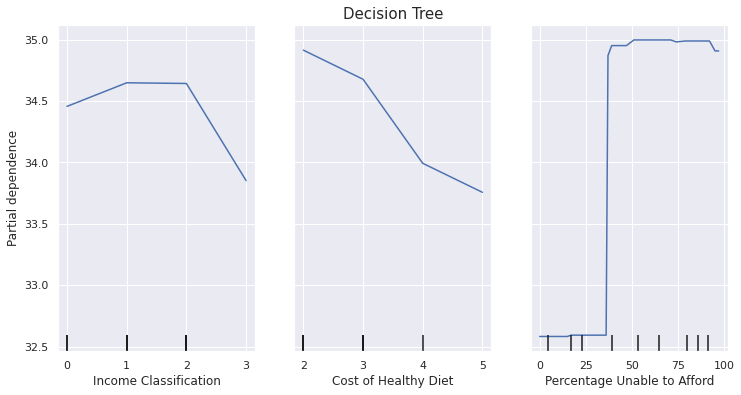

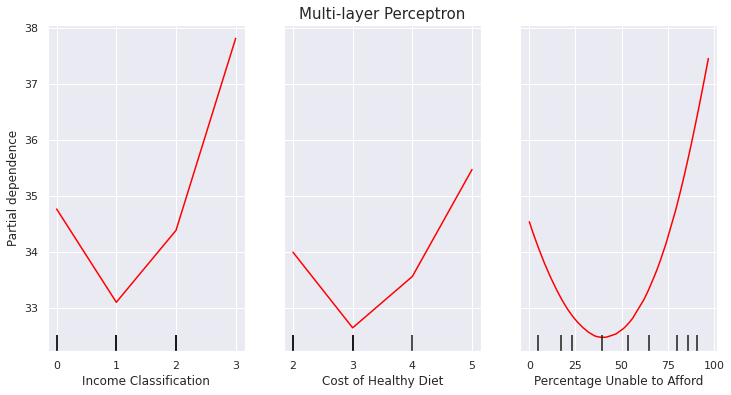

In [ ]:
X_train = X_train.astype(int)

# plot partial dependence curves for features for tree model
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Decision Tree", fontsize=15)
tree_disp = PartialDependenceDisplay.from_estimator(model, X_train, ["Income Classification", "Cost of Healthy Diet", "Percentage Unable to Afford"], ax=ax)

# plot partial dependence curves for features for mlp model
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Multi-layer Perceptron", fontsize=15)
mlp_disp = PartialDependenceDisplay.from_estimator(mlp, X_train, ["Income Classification", "Cost of Healthy Diet", "Percentage Unable to Afford"], ax=ax, line_kw={"color": "red"})

# Testing

In [ ]:
TOLERANCE = 0.001

def check_approx_equals(expected: Any, received: Any) -> bool:
    """
    Checks received against expected, and returns whether or
    not they match (True if they do, False otherwise).
    If the argument is a float, will do an approximate check.
    If the arugment is a data structure will do an approximate check
    on all of its contents.
    """
    try:
        if type(expected) == dict:
            # first check that keys match, then check that the
            # values approximately match
            return expected.keys() == received.keys() and \
                all([check_approx_equals(expected[k], received[k])
                    for k in expected.keys()])
        elif type(expected) == list or type(expected) == set:
            # Checks both lists/sets contain the same values
            return len(expected) == len(received) and \
                all([check_approx_equals(v1, v2)
                    for v1, v2 in zip(expected, received)])
        elif type(expected) == float:
            return math.isclose(expected, received, abs_tol=TOLERANCE)
        elif type(expected) == np.ndarray:
            return np.allclose(expected, received, abs_tol=TOLERANCE,
                               equal_nan=True)
        elif type(expected) == pd.DataFrame:
            try:
                pd.testing.assert_frame_equal(expected, received,
                                              atol=TOLERANCE)
                return True
            except AssertionError:
                return False
        elif type(expected) == pd.Series:
            try:
                pd.testing.assert_series_equal(expected, received,
                                               atol=TOLERANCE)
                return True
            except AssertionError:
                return False
        else:
            return expected == received
    except Exception as e:
        print(f"EXCEPTION: Raised when checking check_approx_equals {e}")
        return False


def assert_equals(expected: Any, received: Any) -> None:
    """
    Checks received against expected, throws an AssertionError
    if they don't match. If the argument is a float, will do an approximate
    check. If the arugment is a data structure will do an approximate check
    on all of its contents.
    """

    if type(expected) == str:
        # Make sure strings have explicit quotes around them
        err_msg = f'Failed: Expected "{expected}", but received "{received}"'
    elif type(expected) in [np.ndarray, pd.Series, pd.DataFrame]:
        # Want to make multi-line output for data structures
        err_msg = f'Failed: Expected\n{expected}\n\nbut received\n{received}'
    else:
        err_msg = f'Failed: Expected {expected}, but received {received}'

    assert check_approx_equals(expected, received), err_msg

In [ ]:
def test_filter_malnutrition() -> None:
    """
    Tests the filter_malnutrition method, specifically the added average column
    """
    data = filter_malnutrition_data("/content/country-wise-average.csv")
    check_approx_equals(57.793, data["Average"].loc[:0].item())

def test_map_data() -> None:
    """
    Tests the map_data method, specifically the merged data column
    """
    data = filter_malnutrition_data("/content/country-wise-average.csv")
    assert_equals(177, len(map_data(data)))

def test_filter_cost_data() -> None:
    """
    Tests the filter_cost_data method, specifically the merged data column
    """
    data = filter_cost_data("/content/Cost_Affordability_Healthy_Diet_Data.csv")
    assert_equals(220, len(data))

# Client

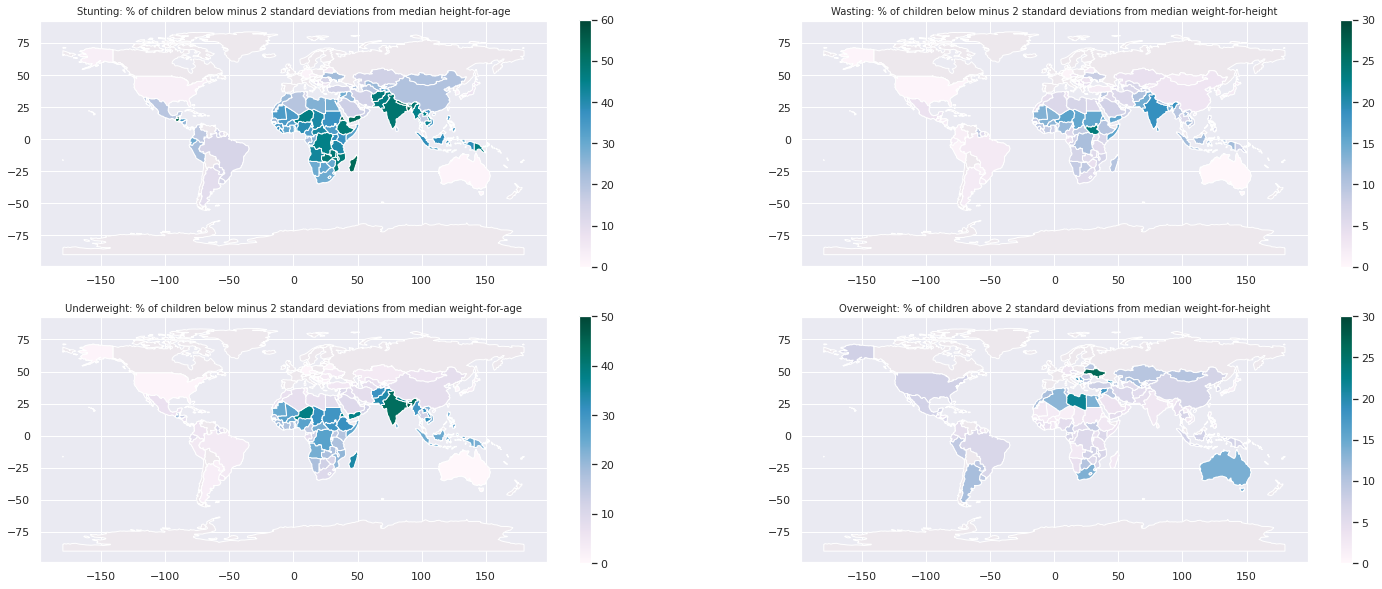

In [ ]:
def main():
  malnutrition_data = filter_malnutrition_data('/content/country-wise-average.csv')
  cost_data = filter_cost_data('/content/Cost_Affordability_Healthy_Diet_Data.csv')

  plot_top_ten_stunting(malnutrition_data)
  plot_top_wasting(malnutrition_data)
  plot_top_underweight(malnutrition_data)
  plot_top_overweight(malnutrition_data)
  plot_global_malnutrition(malnutrition_data)

  plot_highest_overall(malnutrition_data)
  plot_lowest_overall(malnutrition_data)
  plot_lowest_cost(malnutrition_data)

if __name__ == '__main__':
    main()